In [3]:
# -*- coding: utf-8 -*-

from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, ElasticNet

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer,
                             classification_report,                             
                             mean_squared_error, 
                             r2_score, 
                             accuracy_score, 
                             roc_auc_score,
                             precision_score,
                             recall_score,
                             confusion_matrix)

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, 
                                   PolynomialFeatures, StandardScaler,
                                   label_binarize)
from scipy.sparse import csr_matrix

from pdpbox import pdp

from xgboost import XGBRegressor, XGBClassifier

    
    

In [4]:
def engineerTestData(df,log_cols,encoded_cols,freq_cols,
                     mask_cols,token_cols,orig_cols, feats_to_drop,
                     encoder,token_1,token_2):
    df.columns =  df.columns.str.lower()
    df.columns = [col.strip() for col in df.columns]
    df.set_index('listingid',inplace=True)
    df = df.apply(lambda col: col.fillna('Unknown') if col.dtype == 'O' else col.fillna(0))
    
    [df.__setitem__(col, np.log(np.ceil(df[col]))) for col in log_cols]
    [df.__setitem__(col, df[col].map(df[col].value_counts())) for col in freq_cols]
    [df.__setitem__(col, df[col].astype(int)) for col in mask_cols]

    handle_encode = orig_cols 
    test_encode = df[encoded_cols]
    for col in handle_encode:
        col = col.strip()   
        func_name = 'handle_' + col  # Prepare function name
        if func_name in globals() and callable(globals()[func_name]):
            func = globals()[func_name]
            if col == 'vehdrivetrain':
                temp_df = func(df[col].copy())  # Call the function dynamically
                test_encode[col] = temp_df
            elif col == 'vehhistory':
                df.loc[df[col] == 'Unknown', col] = 0
                temp_df = df[col].copy().str.split(',',n=1,expand=True)
                temp_df.columns = ['Owners', 'History']
                temp_df['Owners'] = temp_df['Owners'].str.extract(r'^(\d+)')
                encoded_hist = func(temp_df['History'])  # Call the function dynamically
                df['owners'] = temp_df['Owners']
                df[encoded_hist.columns] = encoded_hist
            elif col == 'vehengine':
                temp_df = func(df[col].copy())  # Call the function dynamically
                temp_df.columns = temp_df.columns.str.lower()
                df[temp_df.columns] = temp_df
            elif col == 'vehcolorext':
                col_temp = func(df[col].copy())  # Call the function dynamically
                col_temp.columns = col_temp.columns.str.lower()
            elif col == 'vehcolorint':
                col_tmp = func(df[col].copy())  # Call the function dynamically
                col_tmp.columns = col_tmp.columns.str.lower()            
        else:
            print(f"Function '{func_name}' does not exist or is not callable.")

    colors = pd.merge(col_temp,col_tmp,left_index=True, right_index=True)
    df = pd.merge(df,colors,left_index=True, right_index=True)
    temp_encoded = oHotEncode(test_encode,encoder)
    df.drop(columns=encoded_cols,inplace=True)
    df = pd.merge(df,temp_encoded,left_index=True, right_index=True)
    df.columns = df.columns.astype(str)

    tf1 = tf_idfTokenizer(df[token_cols[0]].copy(),token_1)
    tf2 = tf_idfTokenizer(df[token_cols[1]].copy(),token_2)
    #tfs = pd.concat([tf1, tf2])
    #tfs = combined_tf.loc[:,~combined_tf.columns.duplicated()] 
    tfs = pd.merge(tf1, tf2,left_index=True,right_index=True)
    df = pd.merge(df,tfs,left_index=True,right_index=True)
    df.drop(columns=feats_to_drop,inplace=True)
    
    return df
    
def oHotEncode(df,coder):
    encoded_mat = coder.transform(df)
    return pd.DataFrame(encoded_mat.todense(),
                        columns=[cat for columns in encoder.categories_ for cat in columns],
                        index=df.index)

    
def zScoreTransform(col):
    return np.divide(np.subtract(col,col.mean()),col.std())

    
def tf_idfTokenizer(df_,tfidf):
    tf_mat = tfidf.transform(df_)
    return pd.DataFrame(tf_mat.toarray(),
                          columns=tfidf.get_feature_names_out(['feature']),
                          index=df_.index)

    
def setFeatPtr(data,index):
    return data.iloc[:,index],data.columns[index]


def plotDist(data,title):
    # Plotting a histogram of frequencies
    fig, ax = plt.subplots()
    sns.histplot(data, kde=True, ax=ax)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()

def categorize_train(phrase, awd_pattern, fwd_pattern, wd_pattern):
    if re.search(awd_pattern, phrase) and re.search(wd_pattern, phrase):
        return 'hybrid'
    elif re.search(awd_pattern, phrase):
        return 'awd'
    elif re.search(fwd_pattern, phrase):
        return 'fwd'
    elif re.search(wd_pattern, phrase):
        return '_4_wd'
    else:
        return 'Unknown'

def handle_vehdrivetrain(df):
    df = df.str.lower()
    awd_pattern = re.compile(r'awd|all', flags=re.IGNORECASE)
    fwd_pattern = re.compile(r'fwd|front', flags=re.IGNORECASE)
    wd_pattern = re.compile(r'4x4|4wd|four\s?WHEEL\s?DRIVE\b', flags=re.IGNORECASE)
    return df.apply(categorize_train, args=(awd_pattern, fwd_pattern, wd_pattern))

# Function extracts engine size and configuration
def categorize_engine(phrase):
    engine_size_match = re.search(r'\b\d+(\.\d+)?\s*L\b', phrase)  # Matches pattern with number (with or without decimal) followed by L
    config_match = re.search(r'V[-]?6|V[-]?8|\b\d\s*cylinder|\b6\s*cylinde', phrase, re.IGNORECASE)  # Matches V6, V-6, V8, V-8, or a number followed by cylinders

    if engine_size_match:
        engine_size = float(re.search(r'\d+(\.\d+)?', engine_size_match.group()).group())  # Extracts engine size
        size_category = engine_size  # Assigning the engine size directly as the size category
    else:
        size_category = 0

    if config_match:
        config_str = config_match.group().upper()
        config = 6 if '6' in config_str else 8  # Assign 6 or 8 based on the presence of 'Vx' or 'Cyclinders'
    else:
        config = 0

    return size_category, config

def handle_vehengine(df):
    extracted_info = df.apply(categorize_engine)
    # Convert the extracted information into a DataFrame
    df = pd.DataFrame(extracted_info.tolist(), columns=['EngineSize', 'Cylinders'], index=df.index)
    return df

def handle_vehhistory(df):
    print("HISTORY")
    # List of unique phrases
    unique_phrases = [
        'Accident(s) Reported',
        'Buyback Protection Eligible',
        'Non-Personal Use Reported',
        'Title Issue(s) Reported'
    ]
    df = df.str.strip()
    # Applies one-hot encoding to the 'History' column based on the unique phrases
    encoded_df = df.str.get_dummies(',').reindex(columns=unique_phrases, fill_value=0)
    # Checks if all columns for the specified phrases contain zeros and create a 'None of the above' column
    encoded_df['None of the above'] = (encoded_df.sum(axis=1) == 0).astype(int)
    encoded_df.index = df.index
    return encoded_df

def handle_vehcolorext(df_):
    print("COLOR")
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Green', 'Steel', 'Metallic','Pearlcoat', 'Clearcoat',
                     'Charcoal','Granite', 'Red', 'Silver', 'White']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

def handle_vehcolorint(df_):
    print("COLOR2")
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Steel', 'Beige','trim',
                     'Charcoal','Red', 'Silver', 'Frost','Maple','Tan','Cirrus','carbon','plum']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

In [5]:
#Initialize training and test dataframes

df_train = pd.read_csv('Training_DataSet.csv')
df_test = pd.read_csv('Test_Dataset.csv')

#Drop blank cells from training set to clean up data (contemplated using mean, median, or mode imputation,
#but will explore without corrupting the data and due to the large size of the dataset eliminating
#some rows should suffice
df_train.dropna(axis=0,how='any',inplace=True) #EXPLICIT CALL TO DROP ROWS WITH A SINGLE MISSING VALUE
                                               #(DEFAULT CALL DOES SAME)

In [6]:
df_train.columns = df_train.columns.str.lower()
df_train.set_index('listingid',inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5045 entries, 4777 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            5045 non-null   object 
 1   sellerispriv          5045 non-null   bool   
 2   sellerlistsrc         5045 non-null   object 
 3   sellername            5045 non-null   object 
 4   sellerrating          5045 non-null   float64
 5   sellerrevcnt          5045 non-null   int64  
 6   sellerstate           5045 non-null   object 
 7   sellerzip             5045 non-null   float64
 8   vehbodystyle          5045 non-null   object 
 9   vehcertified          5045 non-null   bool   
 10  vehcolorext           5045 non-null   object 
 11  vehcolorint           5045 non-null   object 
 12  vehdrivetrain         5045 non-null   object 
 13  vehengine             5045 non-null   object 
 14  vehfeats              5045 non-null   object 
 15  vehfuel             

In [7]:
#NOTICE THERES ONLY JEEPS AND CADILLACS IN DATA SET BRAKE THEM UP FURTHER TO SEE
#THE TRIMS SINCE TRIMS ARE USUALLY EXCLUSIVE TO MANUFACTURER LINE
jeeps = df_train[df_train['vehmake'].str.lower() == 'jeep'].copy()
caddy = df_train[df_train['vehmake'].str.lower() == 'cadillac'].copy()

print(jeeps['vehicle_trim'].value_counts())
print(caddy['vehicle_trim'].value_counts())

vehicle_trim
Limited                             1616
Laredo                               616
Overland                             342
Altitude                             257
Summit                               203
Trailhawk                            149
High Altitude                         74
SRT                                   62
Laredo E                              42
Trackhawk                             27
Sterling Edition                      25
Limited 75th Anniversary Edition       5
75th Anniversary                       4
Upland                                 3
SRT Night                              2
75th Anniversary Edition               1
Name: count, dtype: int64
vehicle_trim
Premium Luxury        658
Luxury                535
Base                  137
Platinum              116
Luxury FWD             49
FWD                    47
Premium Luxury FWD     35
Luxury AWD             19
Platinum AWD           12
Premium Luxury AWD      9
Name: count, dtype: int64


In [8]:
#MASSIVE CLASS IMBALANCE WILL NEED TO CONDENSE THIS AND IGNORE LOW FREQUENCY CLASSES
#BECAUSE THEY ADD NOISE AND CLASSIFIER WILL NOT BE ABLE TO ARBITRATE
conditions = [
    caddy['vehicle_trim'].str.lower().str.contains('premium'),
    caddy['vehicle_trim'].str.lower().str.contains('luxury'),
    caddy['vehicle_trim'].str.lower().str.contains('base'),
    caddy['vehicle_trim'].str.lower().str.contains('platinum')
]

choices = ['Premium', 'Luxury', 'Base', 'Platinum']

# Use np.select() to relabel based on conditions
caddy['vehicle_trim'] = np.select(conditions, choices, default='other')

# Filter the DataFrame to keep only rows labeled as 'premium', 'luxury', 'base', or 'platinum'
valid_labels = ['Premium', 'Luxury', 'Base', 'Platinum']
caddy = caddy[caddy['vehicle_trim'].isin(valid_labels)]
caddy["vehicle_trim"]

listingid
7108        Luxury
21448      Premium
21807       Luxury
30524         Base
34061      Premium
            ...   
8599564    Premium
8601212     Luxury
8604205    Premium
8616294     Luxury
8617378     Luxury
Name: vehicle_trim, Length: 1570, dtype: object

In [9]:
valid_labels_jeep = ['limited', 'laredo',  'summit',
                     'overland', 'altitude','trailhawk','trackhawk','srt']

conditions_jeep = [
    jeeps['vehicle_trim'].str.lower().str.contains(label) for label in valid_labels_jeep
]

choices_jeep = ['Limited', 'Laredo',  'Summit', 
                     'Overland', 'Altitude','Trailhawk','SRT','Trackhawk']

# Use np.select() to classify based on conditions
jeeps['vehicle_trim'] = np.select(conditions_jeep, choices_jeep, default='other')

# Filter the DataFrame to keep only rows labeled with valid labels
jeeps = jeeps[jeeps['vehicle_trim'].isin(choices_jeep)]
jeeps["vehicle_trim"]

listingid
4777          Laredo
6242         Limited
10882        Limited
12013         Laredo
12334        Limited
             ...    
8610847      Limited
8612731     Altitude
8614177      Limited
8615510      Limited
8620012    Trailhawk
Name: vehicle_trim, Length: 3395, dtype: object

In [10]:
print("CADDY")
print(caddy["vehicle_trim"].value_counts())
print("JEEP")
print(jeeps["vehicle_trim"].value_counts())

CADDY
vehicle_trim
Premium     702
Luxury      603
Base        137
Platinum    128
Name: count, dtype: int64
JEEP
vehicle_trim
Limited      1621
Laredo        658
Overland      342
Altitude      331
Summit        203
Trailhawk     149
Trackhawk      64
SRT            27
Name: count, dtype: int64


In [11]:
print(jeeps.index)
print(caddy.index)
df_train.update(jeeps[['vehicle_trim']])
df_train.update(caddy[['vehicle_trim']])
df_train["vehicle_trim"].value_counts()

Index([   4777,    6242,   10882,   12013,   12334,   13173,   17626,   17982,
         20984,   25753,
       ...
       8588930, 8589426, 8595032, 8604328, 8605237, 8610847, 8612731, 8614177,
       8615510, 8620012],
      dtype='int64', name='listingid', length=3395)
Index([   7108,   21448,   21807,   30524,   34061,   34857,   48367,   52528,
         56883,   60529,
       ...
       8567162, 8567842, 8577448, 8584119, 8597526, 8599564, 8601212, 8604205,
       8616294, 8617378],
      dtype='int64', name='listingid', length=1570)


vehicle_trim
Limited                     1621
Premium                      702
Laredo                       658
Luxury                       603
Overland                     342
Altitude                     331
Summit                       203
Trailhawk                    149
Base                         137
Platinum                     128
Trackhawk                     64
FWD                           47
SRT                           27
Sterling Edition              25
75th Anniversary               4
Upland                         3
75th Anniversary Edition       1
Name: count, dtype: int64

In [12]:
options = choices + choices_jeep
df_train = df_train[df_train['vehicle_trim'].isin(options)]

print(df_train["vehicle_trim"].value_counts())
df_train.head()

vehicle_trim
Limited      1621
Premium       702
Laredo        658
Luxury        603
Overland      342
Altitude      331
Summit        203
Trailhawk     149
Base          137
Platinum      128
Trackhawk      64
SRT            27
Name: count, dtype: int64


sellercity  sellerispriv             sellerlistsrc  \
listingid                                                         
4777           Waukesha         False    Jeep Certified Program   
6242         Wentzville         False  Inventory Command Center   
7108       Fayetteville         False        HomeNet Automotive   
10882             Olean         False  Digital Motorworks (DMi)   
12013            Ottawa         False  Digital Motorworks (DMi)   

                                           sellername  sellerrating  \
listingid                                                             
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   
10882          Paul Brown Chrysler Dodge Jeep RAM Kia           3.0   
12013                               Sierra Motor Mall           3.5   

           sellerrevcnt sellerstate  sellerzip vehbodystyle  vehcertified  \
listingid                                                                   
4777               1405          WI    53186.0          SUV          True   
6242                 21          MO    63385.0          SUV         False   
7108                 74          AR    72703.0          SUV         False   
10882                51          NY    14760.0          SUV         False   
12013                17          IL    61350.0          SUV         False   

           ...   vehmake vehmileage        vehmodel vehpricelabel  \
listingid  ...                                                      
4777       ...      Jeep    38957.0  Grand Cherokee     Good Deal   
6242       ...      Jeep    20404.0  Grand Cherokee     Good Deal   
7108       ...  Cadillac    19788.0             XT5     Good Deal   
10882      ...      Jeep    34649.0  Grand Cherokee     Good Deal   
12013      ...      Jeep    48814.0  Grand Cherokee     Good Deal   

                                              vehsellernotes vehtype  \
listingid                                                              
4777       Backed by a rigorous 125-point inspection by f...    Used   
6242       Drop by to see us and you will quickly see how...    Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...    Used   
10882      Priced below KBB Fair Purchase Price! Clean CA...    Used   
12013      2017 Jeep Grand Cherokee Laredo True Blue Pear...    Used   

                  vehtransmission  vehyear vehicle_trim  dealer_listing_price  
listingid                                                                      
4777       8-Speed Automatic w/OD     2015       Laredo               23249.0  
6242                    Automatic     2018      Limited               31977.0  
7108            8-Speed Automatic     2018       Luxury               33495.0  
10882           8-Speed Automatic     2018      Limited               27900.0  
12013           8-Speed Automatic     2017       Laredo               22989.0  

[5 rows x 28 columns]

In [13]:
feats_to_drop = []
encoded_cols = []
freq_cols = []
same_cols = []
mask_cols = []
log_cols = [] 
orig_cols = []

input_data = df_train.copy()
input_data = input_data.iloc[:,:-2]

col = 0
feat_ptr,column = setFeatPtr(input_data,col)

In [14]:
feat_ptr.head()

listingid
4777         Waukesha
6242       Wentzville
7108     Fayetteville
10882           Olean
12013          Ottawa
Name: sellercity, dtype: object

In [15]:
#PERCENTAGE MODE APPEARS
count = (feat_ptr==feat_ptr.mode()[0]).sum()
print(count/len(feat_ptr))
print(feat_ptr.nunique())

0.021349446122860022
1126


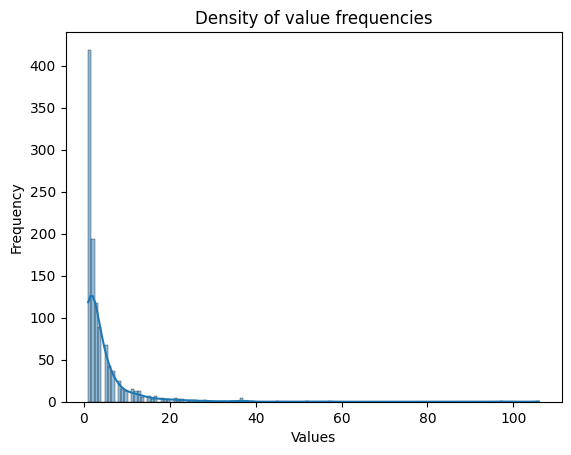

sellercity
Chicago             14.428481
Battle Creek        13.150249
Columbus             7.469218
Louisville           6.759089
Atlanta              5.764909
                      ...    
Ellwood City        -0.484225
Plymouth Meeting    -0.484225
Carmel              -0.484225
Big Stone Gap       -0.484225
Vincennes           -0.484225
Name: count, Length: 1126, dtype: float64


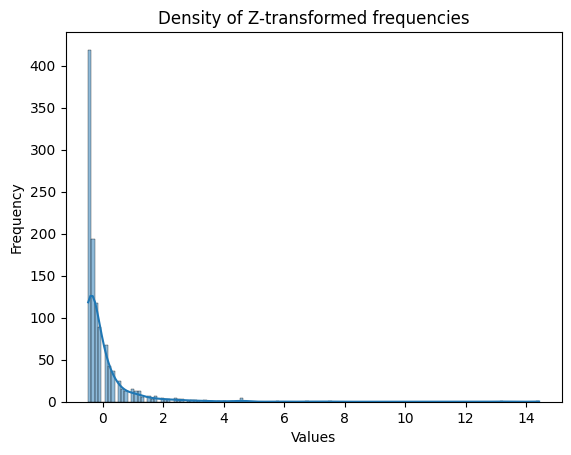

<Figure size 800x600 with 0 Axes>

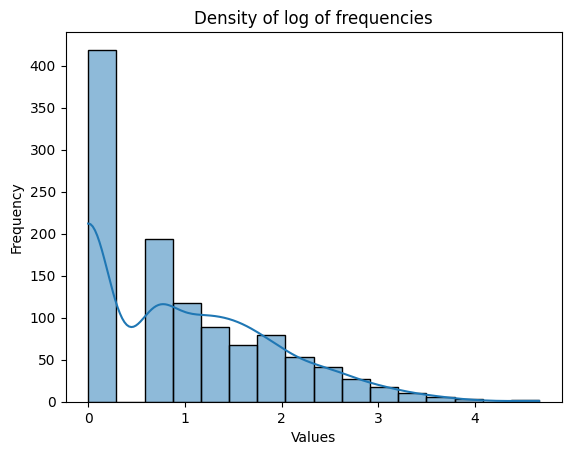

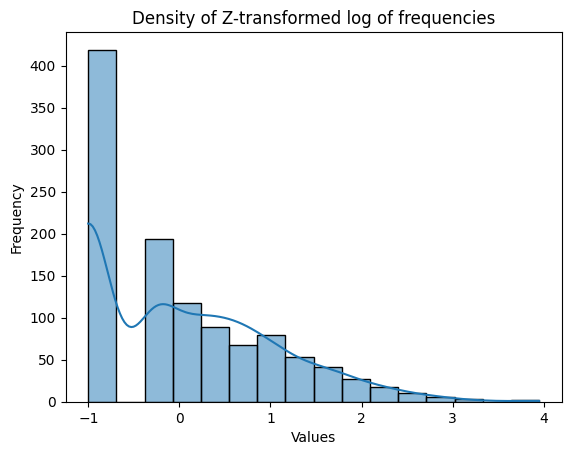

listingid
4777     21
6242      4
7108      7
10882     2
12013     7
Name: sellercity, dtype: int64

In [16]:
value_counts = feat_ptr.value_counts()
# Plotting a histogram of frequencies (Frequencies of Frequencies)
plotDist(value_counts,"Density of value frequencies")
#FREQUENCY ENCODE THESE VALUES AND THEN TAKE Z SCORE OR THE FREQUENCIES
zvalues = zScoreTransform(value_counts)
print(zvalues)
plotDist(zvalues,"Density of Z-transformed frequencies")
# Assuming 'value_counts' contains the frequencies
log_frequencies = np.log(value_counts)
# Plotting the density plot of the log of frequencies
plt.figure(figsize=(8, 6))
plotDist(log_frequencies,"Density of log of frequencies")
# Plotting the density plot of the log of frequencies
zlog = zScoreTransform(log_frequencies)
plotDist(zlog,"Density of Z-transformed log of frequencies")
freq = feat_ptr.value_counts().to_dict()
feat_ptr = feat_ptr.map(freq)
feat_ptr.head()

In [17]:
input_data[column] = feat_ptr
input_data.head()

sellercity  sellerispriv             sellerlistsrc  \
listingid                                                       
4777               21         False    Jeep Certified Program   
6242                4         False  Inventory Command Center   
7108                7         False        HomeNet Automotive   
10882               2         False  Digital Motorworks (DMi)   
12013               7         False  Digital Motorworks (DMi)   

                                           sellername  sellerrating  \
listingid                                                             
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   
10882          Paul Brown Chrysler Dodge Jeep RAM Kia           3.0   
12013                               Sierra Motor Mall           3.5   

           sellerrevcnt sellerstate  sellerzip vehbodystyle  vehcertified  \
listingid                                                                   
4777               1405          WI    53186.0          SUV          True   
6242                 21          MO    63385.0          SUV         False   
7108                 74          AR    72703.0          SUV         False   
10882                51          NY    14760.0          SUV         False   
12013                17          IL    61350.0          SUV         False   

           ...                                         vehhistory vehlistdays  \
listingid  ...                                                                  
4777       ...               1 Owner, Buyback Protection Eligible   28.107014   
6242       ...  1 Owner, Non-Personal Use Reported, Buyback Pr...   59.816875   
7108       ...  1 Owner, Non-Personal Use Reported, Buyback Pr...   98.665301   
10882      ...  1 Owner, Non-Personal Use Reported, Buyback Pr...   30.967500   
12013      ...  1 Owner, Accident(s) Reported, Non-Personal Us...  194.482338   

            vehmake vehmileage        vehmodel vehpricelabel  \
listingid                                                      
4777           Jeep    38957.0  Grand Cherokee     Good Deal   
6242           Jeep    20404.0  Grand Cherokee     Good Deal   
7108       Cadillac    19788.0             XT5     Good Deal   
10882          Jeep    34649.0  Grand Cherokee     Good Deal   
12013          Jeep    48814.0  Grand Cherokee     Good Deal   

                                              vehsellernotes  vehtype  \
listingid                                                               
4777       Backed by a rigorous 125-point inspection by f...     Used   
6242       Drop by to see us and you will quickly see how...     Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...     Used   
10882      Priced below KBB Fair Purchase Price! Clean CA...     Used   
12013      2017 Jeep Grand Cherokee Laredo True Blue Pear...     Used   

                  vehtransmission  vehyear  
listingid                                   
4777       8-Speed Automatic w/OD     2015  
6242                    Automatic     2018  
7108            8-Speed Automatic     2018  
10882           8-Speed Automatic     2018  
12013           8-Speed Automatic     2017  

[5 rows x 26 columns]

In [18]:
freq_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     False
6242     False
7108     False
10882    False
12013    False
Name: sellerispriv, dtype: bool

In [19]:
feat_ptr.value_counts()

sellerispriv
False    4965
Name: count, dtype: int64

In [20]:
feats_to_drop.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
print(feat_ptr.nunique())
feat_ptr.unique()

5


array(['Jeep Certified Program', 'Inventory Command Center',
       'HomeNet Automotive', 'Digital Motorworks (DMi)',
       'My Dealer Center'], dtype=object)

In [21]:
#A CATEGORY COLUMN EASY TO ONE HOT ENCODE WITH A SMALL ENUMERATION AMOUNT (ONLY REQUIRES
# 5 COLUMNS TO ENCODE)
encoded_cols.append(column)
print(feat_ptr)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777         Jeep Certified Program
6242       Inventory Command Center
7108             HomeNet Automotive
10882      Digital Motorworks (DMi)
12013      Digital Motorworks (DMi)
                     ...           
8614177    Digital Motorworks (DMi)
8615510    Digital Motorworks (DMi)
8616294    Digital Motorworks (DMi)
8617378    Digital Motorworks (DMi)
8620012          HomeNet Automotive
Name: sellerlistsrc, Length: 4965, dtype: object


listingid
4777     Wilde Chrysler Jeep Dodge Ram &amp; Subaru
6242                Century Dodge Chrysler Jeep RAM
7108             Superior Buick GMC of Fayetteville
10882        Paul Brown Chrysler Dodge Jeep RAM Kia
12013                             Sierra Motor Mall
Name: sellername, dtype: object

In [22]:
print(feat_ptr.value_counts()[feat_ptr.mode()]/len(feat_ptr))
feat_ptr.value_counts().head(30)

sellername
Vroom (Online Dealer - Nationwide Delivery)    0.059617
Name: count, dtype: float64


sellername
Vroom (Online Dealer - Nationwide Delivery)                296
Carvana                                                    236
Henkel Chrysler Dodge Jeep Ram                              95
Marino Chrysler Jeep Dodge RAM                              34
Barnett Chrysler Jeep Kia                                   32
F.C. Kerbeck &amp; Sons                                     32
Sewell Cadillac of Dallas                                   32
OffLeaseOnly.com The Nation&#x27;s Used Car Destination     30
Blue Knob Auto Sales                                        28
CarMax White Marsh                                          24
Cross Chrysler Jeep Fiat                                    23
Larry Roesch Dodge Chrysler Jeep RAM                        23
Park Chrysler Jeep                                          21
Germain Cadillac of Easton                                  20
Westgate Chrysler Jeep Dodge RAM                            19
Ron Carter Cadillac Hyundai                 

In [23]:
#NOT CATEGORICAL OR CONTAINS DOMINATE VALUES, WILL NOT SIGNFICANTLY IMPACT MODEL PREDICTION EFFICIENCY
feats_to_drop.append(column)

In [24]:
col +=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     4.8
6242     4.4
7108     3.7
10882    3.0
12013    3.5
Name: sellerrating, dtype: float64

In [25]:
#POSSIBLY NORMALIZE (Z-TRANSFORM) FOR NOW KEEP IT INTACT
same_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     1405
6242       21
7108       74
10882      51
12013      17
Name: sellerrevcnt, dtype: int64

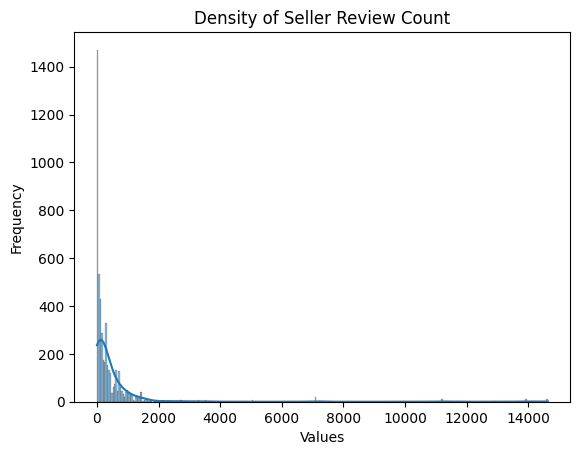

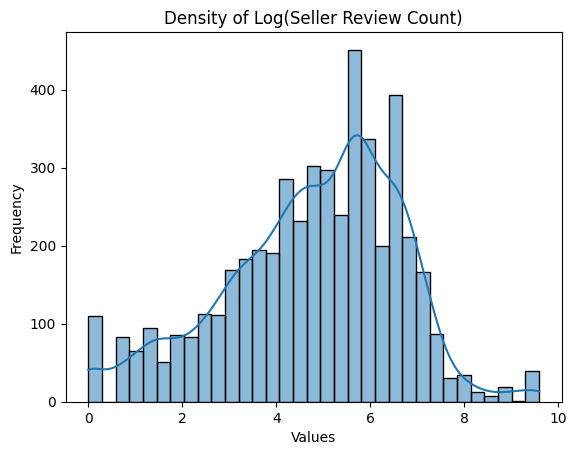

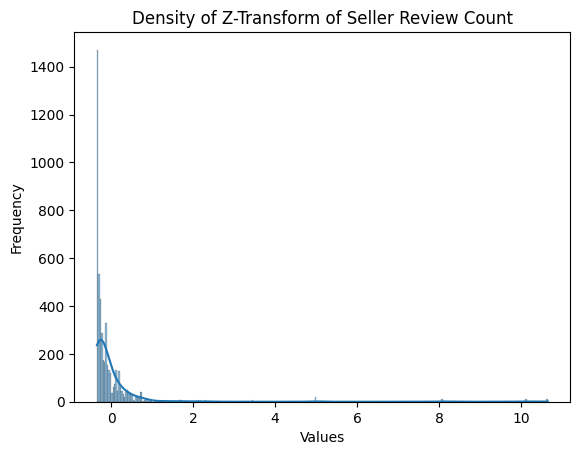

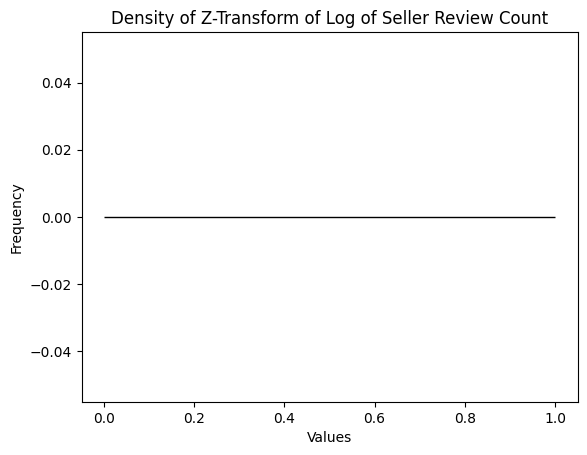

In [26]:
plotDist(feat_ptr,'Density of Seller Review Count')
plotDist(np.log(feat_ptr),'Density of Log(Seller Review Count)')
plotDist(zScoreTransform(feat_ptr),'Density of Z-Transform of Seller Review Count')
plotDist(zScoreTransform(np.log(feat_ptr)),'Density of Z-Transform of Log of Seller Review Count')


In [27]:
#KEEP REVIEW COUNT AS IS FOR NOW
same_cols.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     WI
6242     MO
7108     AR
10882    NY
12013    IL
Name: sellerstate, dtype: object

In [28]:
#STATES -> CATEGORICAL
encoded_cols.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.nunique()

1522

In [29]:
#ZIP SEEMS REDUNDANT WITH CITY/STATE INFO ALREADY EXISTING
#PLUS THE AMOUNT OF VARYING ZIPS PROVIDES NOISY DATA
feats_to_drop.append(column)
print(feats_to_drop)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

['sellerispriv', 'sellername', 'sellerzip']


listingid
4777     SUV
6242     SUV
7108     SUV
10882    SUV
12013    SUV
Name: vehbodystyle, dtype: object

In [30]:
feat_ptr.nunique()

1

In [31]:
#ALL SUV, MEANINGLESS DATA
feats_to_drop.append(column)
col+=1
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777      True
6242     False
7108     False
10882    False
12013    False
Name: vehcertified, dtype: bool

In [32]:
#MASK BOOLEANS AS 1 AND 0's
feat_ptr = (feat_ptr).astype(int)
input_data[column] = feat_ptr
mask_cols.append(column)

col+=1
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Brilliant Black Crystal Pearlcoat
6242       Diamond Black Crystal Pearlcoat
7108               Radiant Silver Metallic
10882     Billet Silver Metallic Clearcoat
12013                  True Blue Pearlcoat
Name: vehcolorext, dtype: object

In [33]:
feat_ptr.value_counts()

vehcolorext
Bright White Clearcoat               523
Brilliant Black Crystal Pearlcoat    336
Billet Silver Metallic Clearcoat     331
Stellar Black Metallic               289
Radiant Silver Metallic              245
                                    ... 
Billett Silver Clearcoat Metallic      1
Redline Pearl Coat                     1
Ruby Red Metallic                      1
Silver Awd Pano Roof Loaded            1
Stellar Black M                        1
Name: count, Length: 142, dtype: int64

In [34]:
temp_df = handle_vehcolorext(feat_ptr)
temp_df.columns = temp_df.columns.str.lower()

#Encoded with hand-written function rather than the encoder
self_encode = pd.DataFrame(temp_df, index=temp_df.index,columns=temp_df.columns)
orig_cols.append(column)
#Want to drop original
feats_to_drop.append(column)

print(temp_df.sum())
print(temp_df[temp_df["none"]==1].index)

COLOR
black        1241
blue          240
brown          55
green          14
metallic     1806
pearlcoat     811
clearcoat    1323
granite       633
red           532
silver       1047
white        1007
none          114
dtype: int64
Index([ 287172,  528899,  736178,  792826,  816014,  822663,  827114,  860178,
        989049,  993403,
       ...
       7977183, 7999952, 8001660, 8043488, 8147827, 8164007, 8182771, 8255035,
       8257649, 8400784],
      dtype='int64', name='listingid', length=114)


In [35]:
col+=1
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.value_counts().head(50)

vehcolorint
Black                                                 2695
Jet Black                                              747
Shara Beige                                            236
Sahara Beige                                           143
Cirrus                                                 131
Black Leather                                           91
black                                                   86
Light Frost                                             83
Maple Sugar                                             67
Brown                                                   54
Tan                                                     53
Lt Frost Beige/Black                                    52
Ruby Red/Black                                          47
Ruby Red                                                42
Light Frost/Brown                                       39
Light Frost Beige / Black                               32
jet black                                   

In [36]:
temp_df = handle_vehcolorint(feat_ptr)
temp_df.columns = temp_df.columns.str.lower()

#Merge two handwritten encoded columns
self_encode = pd.merge(self_encode, temp_df, left_index=True, right_index=True)
orig_cols.append(column)
#Want to drop original
feats_to_drop.append(column)

print(temp_df.sum())
print(temp_df[temp_df["none"]==1].index)

COLOR2
black     3924
blue        18
brown      168
beige      557
trim        11
red        110
silver      38
frost      282
maple       68
tan         58
cirrus     136
carbon      17
plum        15
none        23
dtype: int64
Index([ 903203, 1491106, 2000241, 2028388, 2102637, 2585204, 2729520, 2839309,
       2842810, 3198504, 3409549, 4761924, 4833074, 4904298, 5013738, 5102938,
       5252166, 5538849, 6022159, 6400857, 6475088, 7504666, 8084993],
      dtype='int64', name='listingid')


In [37]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     4x4/4WD
6242         4WD
7108         FWD
10882        4WD
12013        4WD
Name: vehdrivetrain, dtype: object

In [38]:
feat_ptr.value_counts()

vehdrivetrain
4WD                                                           3310
FWD                                                            903
AWD                                                            630
4X4                                                             32
Four Wheel Drive                                                29
All Wheel Drive                                                 18
Front Wheel Drive                                               16
4x4/4WD                                                          9
4x4                                                              6
AWD or 4x4                                                       5
All-wheel Drive                                                  3
ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL       1
ALL WHEEL                                                        1
AllWheelDrive                                                    1
4WD/AWD                                         

In [39]:
#BASED OFF UNIQUE VALUES SEPERATE INTO 4WD,FWD,or AWD
temp_df = handle_vehdrivetrain(feat_ptr)
temp_df.value_counts()

vehdrivetrain
_4_wd     3386
fwd        919
awd        654
hybrid       6
Name: count, dtype: int64

In [40]:
encoded_cols.append(column)
input_data[column] = temp_df
orig_cols.append(column)
col+=1
print(encoded_cols)
print(input_data[column])

['sellerlistsrc', 'sellerstate', 'vehdrivetrain']
listingid
4777       _4_wd
6242       _4_wd
7108         fwd
10882      _4_wd
12013      _4_wd
           ...  
8614177    _4_wd
8615510    _4_wd
8616294      fwd
8617378      fwd
8620012    _4_wd
Name: vehdrivetrain, Length: 4965, dtype: object


In [41]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehengine
3.6L V6 24V MPFI DOHC                  1563
3.6L V6 24V GDI DOHC                    920
Regular Unleaded V-6 3.6 L/220          547
Gas V6 3.6L/222.6                       317
3.6L V6 24V MPFI DOHC Flexible Fuel     301
                                       ... 
5.7L V8 OHV 16V                           1
V6 3.6L Natural Aspiration                1
6.4L 8 Cylinder Engine                    1
6.4L V8                                   1
6.2L 8 Cyl.                               1
Name: count, Length: 82, dtype: int64

In [42]:
#handle_vehengine takes the vehEngine column and turns it into a 
#2 column data frame by splitting the phrases into engine size 
#and cyclinder configuration
temp_df = handle_vehengine(feat_ptr)
print(temp_df["EngineSize"].value_counts())
print(temp_df["Cylinders"].value_counts())
# '0' represents unknown for either columns

EngineSize
3.6    4506
5.7     192
0.0     144
6.4      63
3.0      37
6.2      23
Name: count, dtype: int64
Cylinders
6    4580
8     273
0     112
Name: count, dtype: int64


In [43]:
input_data[temp_df.columns] = temp_df
orig_cols.append(column)
feats_to_drop.append(column)
col+=1
print(encoded_cols)
temp_df.head()

['sellerlistsrc', 'sellerstate', 'vehdrivetrain']


EngineSize  Cylinders
listingid                       
4777              3.6          6
6242              3.6          6
7108              3.6          6
10882             3.6          6
12013             3.6          6

In [44]:
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
6242     ['Android Auto', 'Antilock Brakes', 'Apple Car...
7108     ['4-Wheel Disc Brakes', 'ABS', 'Adjustable Ste...
10882    ['1st and 2nd row curtain head airbags', '4-wh...
12013    ['1st and 2nd row curtain head airbags', '4-wh...
Name: vehfeats, dtype: object

In [45]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tf_feats = TfidfVectorizer(max_df=0.50,max_features=25)
temp_df = feat_ptr.copy()
tf_feats = tf_feats.fit(temp_df)
vocab1 = tf_idfTokenizer(temp_df,tf_feats)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab1.head()

air     alarm  aluminum        am      anti    assist  \
listingid                                                               
4777       0.000000  0.000000  0.362416  0.331774  0.000000  0.000000   
6242       0.000000  0.000000  0.000000  0.000000  0.000000  0.325096   
7108       0.000000  0.000000  0.431268  0.394806  0.000000  0.000000   
10882      0.000000  0.361018  0.000000  0.000000  0.350011  0.286657   
12013      0.353093  0.000000  0.000000  0.313278  0.000000  0.000000   

               auto  automatic  auxiliary  auxilliary  ...    engine  \
listingid                                              ...             
4777       0.379773   0.312740   0.383067    0.000000  ...  0.000000   
6242       0.476183   0.000000   0.480313    0.000000  ...  0.000000   
7108       0.451923   0.372155   0.000000    0.000000  ...  0.000000   
10882      0.000000   0.000000   0.000000    0.352071  ...  0.319201   
12013      0.000000   0.295304   0.000000    0.300689  ...  0.272616   

                 fm     front     input    memory  premium     slot  speakers  \
listingid                                                                       
4777       0.329535  0.000000  0.383502  0.000000      0.0  0.00000       0.0   
6242       0.000000  0.000000  0.480858  0.000000      0.0  0.00000       0.0   
7108       0.392141  0.000000  0.000000  0.000000      0.0  0.00000       0.0   
10882      0.000000  0.340176  0.000000  0.000000      0.0  0.00000       0.0   
12013      0.311163  0.290530  0.000000  0.295134      0.0  0.30675       0.0   

              theft    wheels  
listingid                      
4777       0.000000  0.337845  
6242       0.000000  0.000000  
7108       0.000000  0.402029  
10882      0.361676  0.000000  
12013      0.000000  0.000000  

[5 rows x 25 columns]

In [46]:
#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
tokenize_cols = [column]
input_data.head()

sellercity  sellerispriv             sellerlistsrc  \
listingid                                                       
4777               21         False    Jeep Certified Program   
6242                4         False  Inventory Command Center   
7108                7         False        HomeNet Automotive   
10882               2         False  Digital Motorworks (DMi)   
12013               7         False  Digital Motorworks (DMi)   

                                           sellername  sellerrating  \
listingid                                                             
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   
10882          Paul Brown Chrysler Dodge Jeep RAM Kia           3.0   
12013                               Sierra Motor Mall           3.5   

           sellerrevcnt sellerstate  sellerzip vehbodystyle  vehcertified  \
listingid                                                                   
4777               1405          WI    53186.0          SUV             1   
6242                 21          MO    63385.0          SUV             0   
7108                 74          AR    72703.0          SUV             0   
10882                51          NY    14760.0          SUV             0   
12013                17          IL    61350.0          SUV             0   

           ...   vehmake vehmileage        vehmodel vehpricelabel  \
listingid  ...                                                      
4777       ...      Jeep    38957.0  Grand Cherokee     Good Deal   
6242       ...      Jeep    20404.0  Grand Cherokee     Good Deal   
7108       ...  Cadillac    19788.0             XT5     Good Deal   
10882      ...      Jeep    34649.0  Grand Cherokee     Good Deal   
12013      ...      Jeep    48814.0  Grand Cherokee     Good Deal   

                                              vehsellernotes vehtype  \
listingid                                                              
4777       Backed by a rigorous 125-point inspection by f...    Used   
6242       Drop by to see us and you will quickly see how...    Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...    Used   
10882      Priced below KBB Fair Purchase Price! Clean CA...    Used   
12013      2017 Jeep Grand Cherokee Laredo True Blue Pear...    Used   

                  vehtransmission  vehyear EngineSize  Cylinders  
listingid                                                         
4777       8-Speed Automatic w/OD     2015        3.6          6  
6242                    Automatic     2018        3.6          6  
7108            8-Speed Automatic     2018        3.6          6  
10882           8-Speed Automatic     2018        3.6          6  
12013           8-Speed Automatic     2017        3.6          6  

[5 rows x 28 columns]

In [47]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehfuel
Gasoline         4615
E85 Flex Fuel     310
Diesel             35
Unknown             5
Name: count, dtype: int64

In [48]:
encoded_cols.append(column)

col+=1

In [49]:
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

temp_df = feat_ptr.str.split(',',n=1,expand=True)
temp_df.columns = ['Owners', 'History']
temp_df["History"].unique()

array([' Buyback Protection Eligible',
       ' Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported',
       ' Accident(s) Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Non-Personal Use Reported, Title Issue(s) Reported',
       ' Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       None], dtype=object)

In [50]:
temp_df['Owners'] = temp_df['Owners'].str.extract(r'^(\d+)')
temp_df['Owners'].head()

listingid
4777     1
6242     1
7108     1
10882    1
12013    1
Name: Owners, dtype: object

In [51]:
input_data['Owners'] = temp_df['Owners']
input_data['Owners'].head()

listingid
4777     1
6242     1
7108     1
10882    1
12013    1
Name: Owners, dtype: object

In [52]:
temp_df["History"].value_counts()

History
 Buyback Protection Eligible                                                                              2595
 Non-Personal Use Reported, Buyback Protection Eligible                                                   1765
 Accident(s) Reported, Buyback Protection Eligible                                                         234
 Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible                              165
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported                                  112
 Title Issue(s) Reported                                                                                    40
 Accident(s) Reported, Title Issue(s) Reported                                                              22
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible       7
 Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible                        

In [53]:
#TURNS OUT THAT THESE PHRASES CAN ACTUALLY BE TURNED INTO CATEGORICAL COLUMNS
#EACH ELEMENT IS A COMBINATION OF VARYING SIZE OF THE 4 POSSIBLE UNIQUE PHRASES
#ONE HOT ENCODE WITH A COLUMN FOR EACH PHRASE
encoded_hist = handle_vehhistory(temp_df["History"])
encoded_hist.head()

HISTORY


Accident(s) Reported  Buyback Protection Eligible  \
listingid                                                      
4777                          0                            1   
6242                          0                            0   
7108                          0                            0   
10882                         0                            0   
12013                         1                            0   

           Non-Personal Use Reported  Title Issue(s) Reported  \
listingid                                                       
4777                               0                        0   
6242                               1                        0   
7108                               1                        0   
10882                              1                        0   
12013                              0                        0   

           None of the above  
listingid                     
4777                       0  
6242                       0  
7108                       0  
10882                      0  
12013                      0

In [54]:
#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
self_encode = pd.merge(self_encode, encoded_hist, left_index=True, right_index=True)
orig_cols.append(column)
self_encode.head()

black_x  blue_x  brown_x  green  metallic  pearlcoat  clearcoat  \
listingid                                                                    
4777             1       0        0      0         0          1          0   
6242             1       0        0      0         0          1          0   
7108             0       0        0      0         1          0          0   
10882            0       0        0      0         1          0          1   
12013            0       1        0      0         0          1          0   

           granite  red_x  silver_x  ...  tan  cirrus  carbon  plum  none_y  \
listingid                            ...                                      
4777             0      0         0  ...    0       0       0     0       0   
6242             0      0         0  ...    0       0       0     0       0   
7108             0      0         1  ...    0       1       0     0       0   
10882            0      0         1  ...    0       0       0     0       0   
12013            0      0         0  ...    0       0       0     0       0   

           Accident(s) Reported  Buyback Protection Eligible  \
listingid                                                      
4777                          0                            1   
6242                          0                            0   
7108                          0                            0   
10882                         0                            0   
12013                         1                            0   

           Non-Personal Use Reported  Title Issue(s) Reported  \
listingid                                                       
4777                               0                        0   
6242                               1                        0   
7108                               1                        0   
10882                              1                        0   
12013                              0                        0   

           None of the above  
listingid                     
4777                       0  
6242                       0  
7108                       0  
10882                      0  
12013                      0  

[5 rows x 31 columns]

In [55]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777      28.107014
6242      59.816875
7108      98.665301
10882     30.967500
12013    194.482338
Name: vehlistdays, dtype: float64

In [56]:
#Use ceiling in order to round to whole days and start the listings 
#on day 1 rather than day 0
feat_ptr = pd.Series(np.ceil(feat_ptr),index=feat_ptr.index)
feat_ptr.head()

listingid
4777      29.0
6242      60.0
7108      99.0
10882     31.0
12013    195.0
Name: vehlistdays, dtype: float64

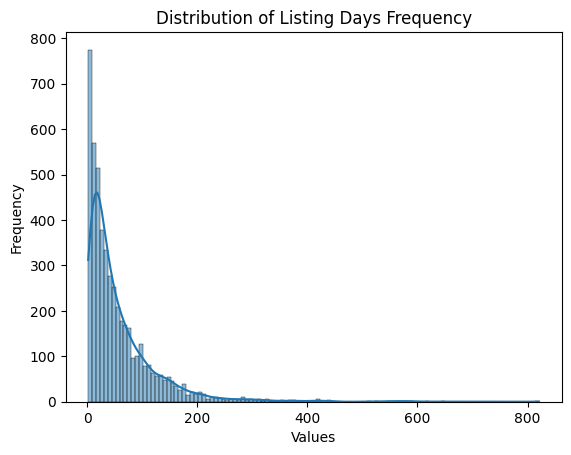

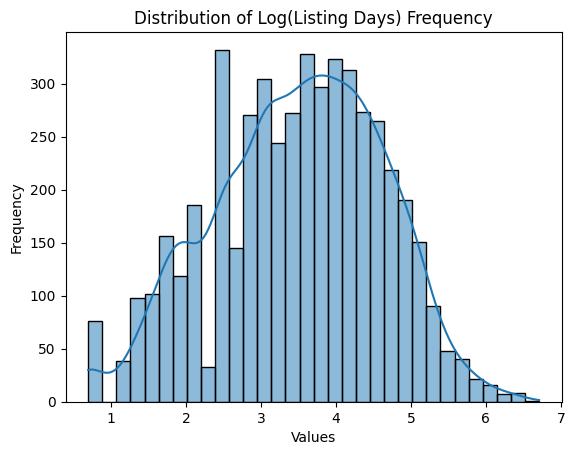

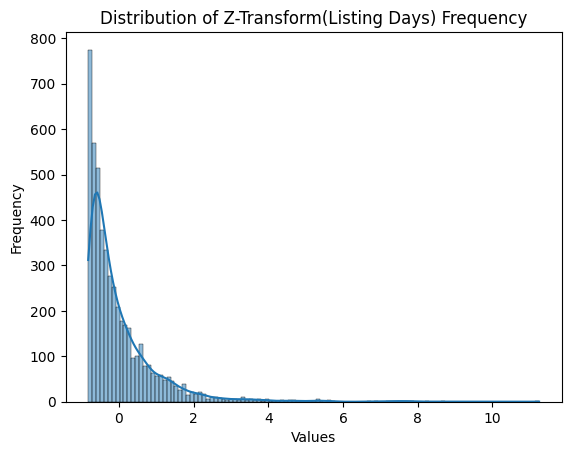

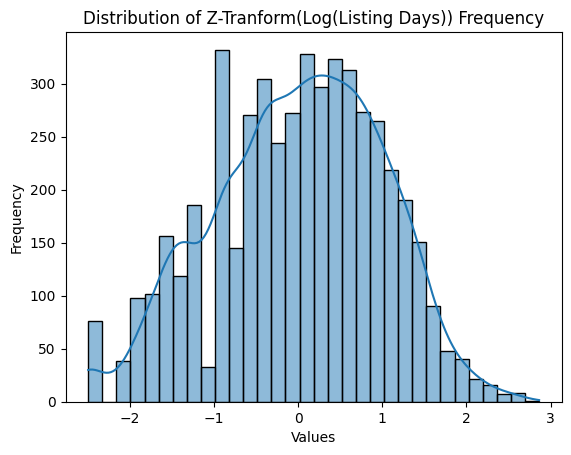

In [57]:
plotDist(feat_ptr,"Distribution of Listing Days Frequency")
plotDist(np.log(feat_ptr),"Distribution of Log(Listing Days) Frequency")
plotDist(zScoreTransform(feat_ptr),"Distribution of Z-Transform(Listing Days) Frequency")
plotDist(zScoreTransform(np.log(feat_ptr)),"Distribution of Z-Tranform(Log(Listing Days)) Frequency")


In [58]:
#CHOOSE LOG VALUE
feat_ptr = np.log(feat_ptr)
feat_ptr.head()

listingid
4777     3.367296
6242     4.094345
7108     4.595120
10882    3.433987
12013    5.273000
Name: vehlistdays, dtype: float64

In [59]:
input_data[column] = feat_ptr
log_cols.append(column)

col+=1
input_data.head()

sellercity  sellerispriv             sellerlistsrc  \
listingid                                                       
4777               21         False    Jeep Certified Program   
6242                4         False  Inventory Command Center   
7108                7         False        HomeNet Automotive   
10882               2         False  Digital Motorworks (DMi)   
12013               7         False  Digital Motorworks (DMi)   

                                           sellername  sellerrating  \
listingid                                                             
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   
10882          Paul Brown Chrysler Dodge Jeep RAM Kia           3.0   
12013                               Sierra Motor Mall           3.5   

           sellerrevcnt sellerstate  sellerzip vehbodystyle  vehcertified  \
listingid                                                                   
4777               1405          WI    53186.0          SUV             1   
6242                 21          MO    63385.0          SUV             0   
7108                 74          AR    72703.0          SUV             0   
10882                51          NY    14760.0          SUV             0   
12013                17          IL    61350.0          SUV             0   

           ... vehmileage        vehmodel vehpricelabel  \
listingid  ...                                            
4777       ...    38957.0  Grand Cherokee     Good Deal   
6242       ...    20404.0  Grand Cherokee     Good Deal   
7108       ...    19788.0             XT5     Good Deal   
10882      ...    34649.0  Grand Cherokee     Good Deal   
12013      ...    48814.0  Grand Cherokee     Good Deal   

                                              vehsellernotes vehtype  \
listingid                                                              
4777       Backed by a rigorous 125-point inspection by f...    Used   
6242       Drop by to see us and you will quickly see how...    Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...    Used   
10882      Priced below KBB Fair Purchase Price! Clean CA...    Used   
12013      2017 Jeep Grand Cherokee Laredo True Blue Pear...    Used   

                  vehtransmission vehyear  EngineSize Cylinders  Owners  
listingid                                                                
4777       8-Speed Automatic w/OD    2015         3.6         6       1  
6242                    Automatic    2018         3.6         6       1  
7108            8-Speed Automatic    2018         3.6         6       1  
10882           8-Speed Automatic    2018         3.6         6       1  
12013           8-Speed Automatic    2017         3.6         6       1  

[5 rows x 29 columns]

In [60]:
feat_ptr, column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777         Jeep
6242         Jeep
7108     Cadillac
10882        Jeep
12013        Jeep
Name: vehmake, dtype: object

In [61]:
encoded_cols.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     38957.0
6242     20404.0
7108     19788.0
10882    34649.0
12013    48814.0
Name: vehmileage, dtype: float64

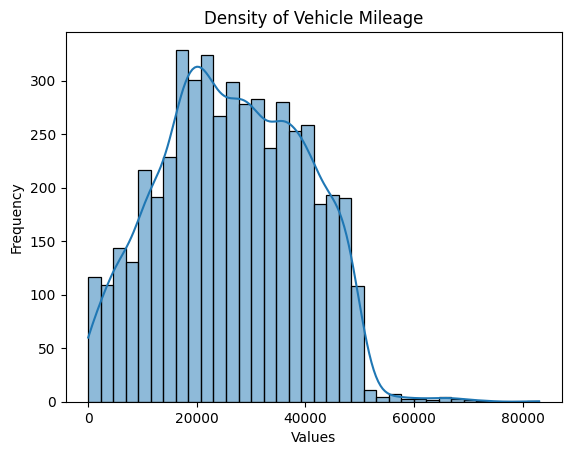

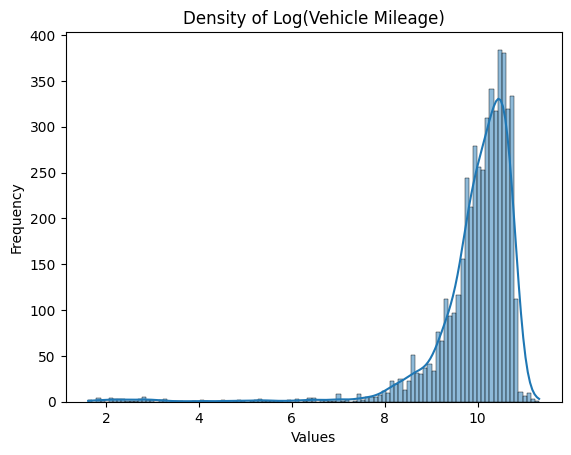

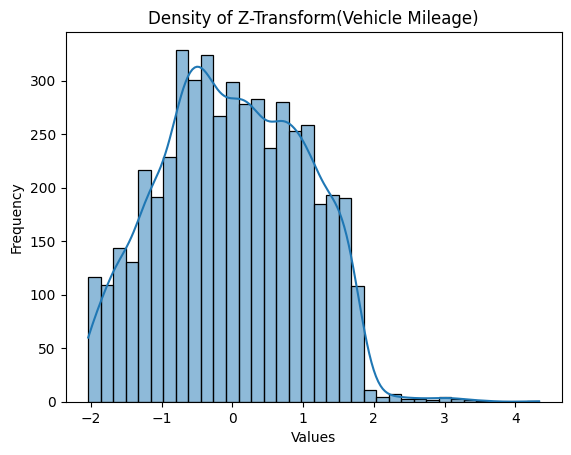

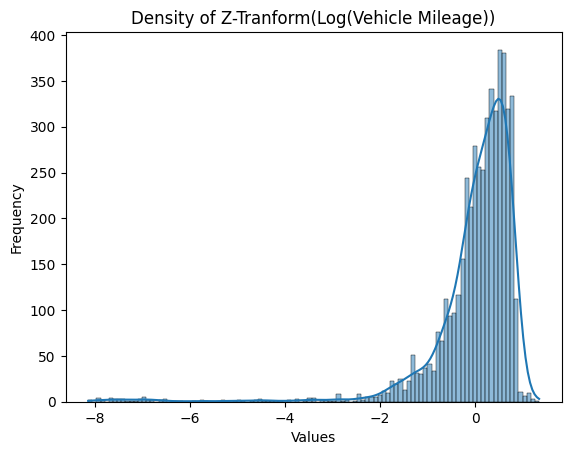

In [62]:
plotDist(feat_ptr,"Density of Vehicle Mileage")
plotDist(np.log(feat_ptr),"Density of Log(Vehicle Mileage)")
plotDist(zScoreTransform(feat_ptr),"Density of Z-Transform(Vehicle Mileage)")
plotDist(zScoreTransform(np.log(feat_ptr)),"Density of Z-Tranform(Log(Vehicle Mileage))")

In [63]:
#ORIGINAL DATA LOOKS ~NORMAL~

same_cols.append(column)
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Grand Cherokee
6242     Grand Cherokee
7108                XT5
10882    Grand Cherokee
12013    Grand Cherokee
Name: vehmodel, dtype: object

In [64]:
#ALREADY HAVE JEEP/CADILLAC ENCODED COLUMNS WHICH HAVE A DIRECT CORRELATION TO THIS
#WILL REMOVE THIS EXTRANEOUS COLUMN
feats_to_drop.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehpricelabel
Good Deal     3714
Great Deal     691
Fair Price     560
Name: count, dtype: int64

In [65]:
encoded_cols.append(column)

col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.head()

listingid
4777     Backed by a rigorous 125-point inspection by f...
6242     Drop by to see us and you will quickly see how...
7108     Luxury, Exterior Parking Camera Rear, Front Du...
10882    Priced below KBB Fair Purchase Price! Clean CA...
12013    2017 Jeep Grand Cherokee Laredo True Blue Pear...
Name: vehsellernotes, dtype: object

In [66]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tfidf = TfidfVectorizer(max_df=.50,max_features=75)
tf_rev = tfidf.fit(feat_ptr.copy())
vocab2 = tf_idfTokenizer(feat_ptr,tf_rev)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab2.head()

4wd        6l       all       amp       are        as  auto  \
listingid                                                                     
4777       0.000000  0.000000  0.125609  0.000000  0.225438  0.000000   0.0   
6242       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
7108       0.000000  0.000000  0.000000  0.000000  0.200296  0.000000   0.0   
10882      0.141334  0.125353  0.000000  0.000000  0.111150  0.000000   0.0   
12013      0.120197  0.000000  0.316012  0.132902  0.000000  0.417727   0.0   

           automatic   be  black  ...        us      used        v6  vehicles  \
listingid                         ...                                           
4777        0.000000  0.0    0.0  ...  0.256734  0.158160  0.000000  0.000000   
6242        0.000000  0.0    0.0  ...  0.327449  0.000000  0.000000  0.000000   
7108        0.000000  0.0    0.0  ...  0.228101  0.140521  0.000000  0.111168   
10882       0.115438  0.0    0.0  ...  0.000000  0.000000  0.118797  0.000000   
12013       0.098175  0.0    0.0  ...  0.000000  0.000000  0.000000  0.000000   

           warranty     wheel    wheels      will       x27  x3d  
listingid                                                         
4777       0.133441  0.000000  0.000000  0.000000  0.126825  0.0  
6242       0.000000  0.000000  0.000000  0.720358  0.323515  0.0  
7108       0.000000  0.110512  0.000000  0.125450  0.225360  0.0  
10882      0.131582  0.000000  0.134801  0.139232  0.000000  0.0  
12013      0.111905  0.104310  0.114642  0.000000  0.212713  0.0  

[5 rows x 75 columns]

In [67]:
#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
tokenize_cols.append(column)
vocabs = pd.merge(vocab1,vocab2,left_index=True,right_index=True)
input_data.head()

sellercity  sellerispriv             sellerlistsrc  \
listingid                                                       
4777               21         False    Jeep Certified Program   
6242                4         False  Inventory Command Center   
7108                7         False        HomeNet Automotive   
10882               2         False  Digital Motorworks (DMi)   
12013               7         False  Digital Motorworks (DMi)   

                                           sellername  sellerrating  \
listingid                                                             
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   
10882          Paul Brown Chrysler Dodge Jeep RAM Kia           3.0   
12013                               Sierra Motor Mall           3.5   

           sellerrevcnt sellerstate  sellerzip vehbodystyle  vehcertified  \
listingid                                                                   
4777               1405          WI    53186.0          SUV             1   
6242                 21          MO    63385.0          SUV             0   
7108                 74          AR    72703.0          SUV             0   
10882                51          NY    14760.0          SUV             0   
12013                17          IL    61350.0          SUV             0   

           ... vehmileage        vehmodel vehpricelabel  \
listingid  ...                                            
4777       ...    38957.0  Grand Cherokee     Good Deal   
6242       ...    20404.0  Grand Cherokee     Good Deal   
7108       ...    19788.0             XT5     Good Deal   
10882      ...    34649.0  Grand Cherokee     Good Deal   
12013      ...    48814.0  Grand Cherokee     Good Deal   

                                              vehsellernotes vehtype  \
listingid                                                              
4777       Backed by a rigorous 125-point inspection by f...    Used   
6242       Drop by to see us and you will quickly see how...    Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...    Used   
10882      Priced below KBB Fair Purchase Price! Clean CA...    Used   
12013      2017 Jeep Grand Cherokee Laredo True Blue Pear...    Used   

                  vehtransmission vehyear  EngineSize Cylinders  Owners  
listingid                                                                
4777       8-Speed Automatic w/OD    2015         3.6         6       1  
6242                    Automatic    2018         3.6         6       1  
7108            8-Speed Automatic    2018         3.6         6       1  
10882           8-Speed Automatic    2018         3.6         6       1  
12013           8-Speed Automatic    2017         3.6         6       1  

[5 rows x 29 columns]

In [68]:
col+=1
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehtype
Used    4965
Name: count, dtype: int64

In [69]:
#ENTIRE COLUMN HAS VALUE "USED".....  DROPPING....
feats_to_drop.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehtransmission
8-Speed Automatic                3765
8-Speed Automatic w/OD            587
Automatic                         268
AUTOMATIC                          69
8-Speed Shiftable Automatic        62
Automatic 8-Speed                  62
8-Speed Automatic (845RE)          48
8-Speed A/T                        44
8-Speed                            11
8-Speed Automatic (850RE)           8
8-Spd TorqueFlite Automatic         7
8 Speed Automatic                   7
8-Speed Automatic (8HP70)           5
Automatic, 8-Spd                    4
8-SPEED AUTOMATIC                   3
Not Specified                       2
6-Speed Automatic                   2
8 speed automatic                   2
A                                   1
automatic                           1
8-Spd Auto 850RE Trans (Make)       1
8-Spd Auto 850RE Trans (Make        1
aujtomatic                          1
Automatic w/OD                      1
8-Speed TorqueFlite Automatic       1
AUTO                              

In [70]:
#BASICALLY ALL 8-SPEED SO IT GETS DROPPED
feats_to_drop.append(column)

col+=1 
feat_ptr,column = setFeatPtr(input_data,col)
feat_ptr.value_counts()

vehyear
2018    1634
2017    1561
2015    1278
2016     380
2019     112
Name: count, dtype: int64

In [71]:
#ONLY 5 UNIQUES IN OUR DATASET SO WE WILL ONE HOT ENCODE THE CATEGORIES
encoded_cols.append(column)

print(encoded_cols)
print(self_encode)
print(tokenize_cols)

['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear']
           black_x  blue_x  brown_x  green  metallic  pearlcoat  clearcoat  \
listingid                                                                    
4777             1       0        0      0         0          1          0   
6242             1       0        0      0         0          1          0   
7108             0       0        0      0         1          0          0   
10882            0       0        0      0         1          0          1   
12013            0       1        0      0         0          1          0   
...            ...     ...      ...    ...       ...        ...        ...   
8614177          1       0        0      0         0          0          0   
8615510          0       0        0      0         0          0          0   
8616294          1       0        0      0         0          0          0   
8617378          1       0        0      0

In [72]:
feats_handled = (log_cols+encoded_cols+freq_cols+same_cols+mask_cols+tokenize_cols+orig_cols)

print(feats_handled)
print(feats_to_drop)

print(len(feats_handled+feats_to_drop))

['vehlistdays', 'sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear', 'sellercity', 'sellerrating', 'sellerrevcnt', 'vehmileage', 'vehcertified', 'vehfeats', 'vehsellernotes', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehhistory']
['sellerispriv', 'sellername', 'sellerzip', 'vehbodystyle', 'vehcolorext', 'vehcolorint', 'vehengine', 'vehfeats', 'vehhistory', 'vehmodel', 'vehsellernotes', 'vehtype', 'vehtransmission']
33


In [73]:
feats_to_drop = [col.strip().lower() for col in feats_to_drop]
input_data.columns = [col.strip().lower() for col in input_data.columns]
input_data.drop(columns=feats_to_drop,inplace=True)
input_data.head()

sellercity             sellerlistsrc  sellerrating  sellerrevcnt  \
listingid                                                                     
4777               21    Jeep Certified Program           4.8          1405   
6242                4  Inventory Command Center           4.4            21   
7108                7        HomeNet Automotive           3.7            74   
10882               2  Digital Motorworks (DMi)           3.0            51   
12013               7  Digital Motorworks (DMi)           3.5            17   

          sellerstate  vehcertified vehdrivetrain   vehfuel  vehlistdays  \
listingid                                                                  
4777               WI             1         _4_wd  Gasoline     3.367296   
6242               MO             0         _4_wd  Gasoline     4.094345   
7108               AR             0           fwd  Gasoline     4.595120   
10882              NY             0         _4_wd  Gasoline     3.433987   
12013              IL             0         _4_wd  Gasoline     5.273000   

            vehmake  vehmileage vehpricelabel  vehyear  enginesize  cylinders  \
listingid                                                                       
4777           Jeep     38957.0     Good Deal     2015         3.6          6   
6242           Jeep     20404.0     Good Deal     2018         3.6          6   
7108       Cadillac     19788.0     Good Deal     2018         3.6          6   
10882          Jeep     34649.0     Good Deal     2018         3.6          6   
12013          Jeep     48814.0     Good Deal     2017         3.6          6   

          owners  
listingid         
4777           1  
6242           1  
7108           1  
10882          1  
12013          1

In [74]:
input_data = pd.merge(input_data,self_encode,left_index=True,right_index=True)
print(self_encode.columns)
input_data.head()

Index(['black_x', 'blue_x', 'brown_x', 'green', 'metallic', 'pearlcoat',
       'clearcoat', 'granite', 'red_x', 'silver_x', 'white', 'none_x',
       'black_y', 'blue_y', 'brown_y', 'beige', 'trim', 'red_y', 'silver_y',
       'frost', 'maple', 'tan', 'cirrus', 'carbon', 'plum', 'none_y',
       'Accident(s) Reported', 'Buyback Protection Eligible',
       'Non-Personal Use Reported', 'Title Issue(s) Reported',
       'None of the above'],
      dtype='object')


sellercity             sellerlistsrc  sellerrating  sellerrevcnt  \
listingid                                                                     
4777               21    Jeep Certified Program           4.8          1405   
6242                4  Inventory Command Center           4.4            21   
7108                7        HomeNet Automotive           3.7            74   
10882               2  Digital Motorworks (DMi)           3.0            51   
12013               7  Digital Motorworks (DMi)           3.5            17   

          sellerstate  vehcertified vehdrivetrain   vehfuel  vehlistdays  \
listingid                                                                  
4777               WI             1         _4_wd  Gasoline     3.367296   
6242               MO             0         _4_wd  Gasoline     4.094345   
7108               AR             0           fwd  Gasoline     4.595120   
10882              NY             0         _4_wd  Gasoline     3.433987   
12013              IL             0         _4_wd  Gasoline     5.273000   

            vehmake  ...  tan cirrus  carbon  plum  none_y  \
listingid            ...                                     
4777           Jeep  ...    0      0       0     0       0   
6242           Jeep  ...    0      0       0     0       0   
7108       Cadillac  ...    0      1       0     0       0   
10882          Jeep  ...    0      0       0     0       0   
12013          Jeep  ...    0      0       0     0       0   

          Accident(s) Reported  Buyback Protection Eligible  \
listingid                                                     
4777                         0                            1   
6242                         0                            0   
7108                         0                            0   
10882                        0                            0   
12013                        1                            0   

           Non-Personal Use Reported  Title Issue(s) Reported  \
listingid                                                       
4777                               0                        0   
6242                               1                        0   
7108                               1                        0   
10882                              1                        0   
12013                              0                        0   

           None of the above  
listingid                     
4777                       0  
6242                       0  
7108                       0  
10882                      0  
12013                      0  

[5 rows x 47 columns]

In [75]:
temp_encoded = input_data[encoded_cols]
print(encoded_cols)
print(temp_encoded.columns)
input_data.head(20)

['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehmake', 'vehpricelabel', 'vehyear']
Index(['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehmake',
       'vehpricelabel', 'vehyear'],
      dtype='object')


sellercity             sellerlistsrc  sellerrating  sellerrevcnt  \
listingid                                                                     
4777               21    Jeep Certified Program           4.8          1405   
6242                4  Inventory Command Center           4.4            21   
7108                7        HomeNet Automotive           3.7            74   
10882               2  Digital Motorworks (DMi)           3.0            51   
12013               7  Digital Motorworks (DMi)           3.5            17   
12334              25  Digital Motorworks (DMi)           4.6           240   
13173              52  Digital Motorworks (DMi)           4.8           774   
17626              11  Inventory Command Center           4.7            69   
17982              10  Digital Motorworks (DMi)           4.7           187   
20984               3  Inventory Command Center           0.0             1   
21448               3        HomeNet Automotive           3.7           629   
21807               4        HomeNet Automotive           4.9           360   
25753              10  Digital Motorworks (DMi)           4.1           368   
26678              13        HomeNet Automotive           4.8           166   
30524               3  Digital Motorworks (DMi)           5.0             4   
31932              17        HomeNet Automotive           4.8           335   
34061               2  Digital Motorworks (DMi)           4.3           312   
34857               4  Inventory Command Center           4.9           622   
35091               3        HomeNet Automotive           4.6            32   
38149               2  Digital Motorworks (DMi)           4.9           865   

          sellerstate  vehcertified vehdrivetrain   vehfuel  vehlistdays  \
listingid                                                                  
4777               WI             1         _4_wd  Gasoline     3.367296   
6242               MO             0         _4_wd  Gasoline     4.094345   
7108               AR             0           fwd  Gasoline     4.595120   
10882              NY             0         _4_wd  Gasoline     3.433987   
12013              IL             0         _4_wd  Gasoline     5.273000   
12334              IL             0         _4_wd  Gasoline     3.367296   
13173              KY             0         _4_wd  Gasoline     1.945910   
17626              MD             0         _4_wd    Diesel     3.367296   
17982              IL             0         _4_wd  Gasoline     1.609438   
20984              IL             0         _4_wd  Gasoline     3.688879   
21448              LA             0           fwd  Gasoline     1.791759   
21807              FL             1           fwd  Gasoline     1.945910   
25753              NY             0         _4_wd  Gasoline     2.708050   
26678              IL             0         _4_wd  Gasoline     4.990433   
30524              TX             0           fwd  Gasoline     2.484907   
31932              TN             0         _4_wd  Gasoline     2.397895   
34061              TX             0           fwd  Gasoline     3.258097   
34857              OH             0           awd  Gasoline     3.663562   
35091              TN             0         _4_wd  Gasoline     3.295837   
38149              MI             0         _4_wd  Gasoline     2.944439   

            vehmake  ...  tan cirrus  carbon  plum  none_y  \
listingid            ...                                     
4777           Jeep  ...    0      0       0     0       0   
6242           Jeep  ...    0      0       0     0       0   
7108       Cadillac  ...    0      1       0     0       0   
10882          Jeep  ...    0      0       0     0       0   
12013          Jeep  ...    0      0       0     0       0   
12334          Jeep  ...    0      0       0     0       0   
13173          Jeep  ...    0      0       0     0       0   
17626          Jeep  ...    0      0     

In [76]:
encoder = OneHotEncoder(handle_unknown='ignore')
coder = encoder.fit(temp_encoded)
temp_encoded.columns = temp_encoded.columns.astype(str)
temp_encoded = oHotEncode(temp_encoded,coder)
temp_encoded.head()

Digital Motorworks (DMi)  HomeNet Automotive  \
listingid                                                 
4777                            0.0                 0.0   
6242                            0.0                 0.0   
7108                            0.0                 1.0   
10882                           1.0                 0.0   
12013                           1.0                 0.0   

           Inventory Command Center  Jeep Certified Program  My Dealer Center  \
listingid                                                                       
4777                            0.0                     1.0               0.0   
6242                            1.0                     0.0               0.0   
7108                            0.0                     0.0               0.0   
10882                           0.0                     0.0               0.0   
12013                           0.0                     0.0               0.0   

            AK   AL   AR   AZ   CA  ...  Cadillac  Jeep  Fair Price  \
listingid                           ...                               
4777       0.0  0.0  0.0  0.0  0.0  ...       0.0   1.0         0.0   
6242       0.0  0.0  0.0  0.0  0.0  ...       0.0   1.0         0.0   
7108       0.0  0.0  1.0  0.0  0.0  ...       1.0   0.0         0.0   
10882      0.0  0.0  0.0  0.0  0.0  ...       0.0   1.0         0.0   
12013      0.0  0.0  0.0  0.0  0.0  ...       0.0   1.0         0.0   

           Good Deal  Great Deal  2015  2016  2017  2018  2019  
listingid                                                       
4777             1.0         0.0   1.0   0.0   0.0   0.0   0.0  
6242             1.0         0.0   0.0   0.0   0.0   1.0   0.0  
7108             1.0         0.0   0.0   0.0   0.0   1.0   0.0  
10882            1.0         0.0   0.0   0.0   0.0   1.0   0.0  
12013            1.0         0.0   0.0   0.0   1.0   0.0   0.0  

[5 rows x 71 columns]

In [77]:
input_data.drop(columns=encoded_cols,inplace=True)
post_feat_eng = pd.merge(input_data,temp_encoded,left_index=True, right_index=True)
post_feat_eng.head()

sellercity  sellerrating  sellerrevcnt  vehcertified  vehlistdays  \
listingid                                                                      
4777               21           4.8          1405             1     3.367296   
6242                4           4.4            21             0     4.094345   
7108                7           3.7            74             0     4.595120   
10882               2           3.0            51             0     3.433987   
12013               7           3.5            17             0     5.273000   

           vehmileage  enginesize  cylinders owners  black_x  ...  Cadillac  \
listingid                                                     ...             
4777          38957.0         3.6          6      1        1  ...       0.0   
6242          20404.0         3.6          6      1        1  ...       0.0   
7108          19788.0         3.6          6      1        0  ...       1.0   
10882         34649.0         3.6          6      1        0  ...       0.0   
12013         48814.0         3.6          6      1        0  ...       0.0   

           Jeep  Fair Price  Good Deal  Great Deal  2015  2016  2017  2018  \
listingid                                                                    
4777        1.0         0.0        1.0         0.0   1.0   0.0   0.0   0.0   
6242        1.0         0.0        1.0         0.0   0.0   0.0   0.0   1.0   
7108        0.0         0.0        1.0         0.0   0.0   0.0   0.0   1.0   
10882       1.0         0.0        1.0         0.0   0.0   0.0   0.0   1.0   
12013       1.0         0.0        1.0         0.0   0.0   0.0   1.0   0.0   

           2019  
listingid        
4777        0.0  
6242        0.0  
7108        0.0  
10882       0.0  
12013       0.0  

[5 rows x 111 columns]

In [78]:
post_feat_eng = pd.merge(post_feat_eng,vocabs,left_index=True, right_index=True)
post_feat_eng.head()

sellercity  sellerrating  sellerrevcnt  vehcertified  vehlistdays  \
listingid                                                                      
4777               21           4.8          1405             1     3.367296   
6242                4           4.4            21             0     4.094345   
7108                7           3.7            74             0     4.595120   
10882               2           3.0            51             0     3.433987   
12013               7           3.5            17             0     5.273000   

           vehmileage  enginesize  cylinders owners  black_x  ...        us  \
listingid                                                     ...             
4777          38957.0         3.6          6      1        1  ...  0.256734   
6242          20404.0         3.6          6      1        1  ...  0.327449   
7108          19788.0         3.6          6      1        0  ...  0.228101   
10882         34649.0         3.6          6      1        0  ...  0.000000   
12013         48814.0         3.6          6      1        0  ...  0.000000   

               used        v6  vehicles  warranty     wheel  wheels_y  \
listingid                                                               
4777       0.158160  0.000000  0.000000  0.133441  0.000000  0.000000   
6242       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7108       0.140521  0.000000  0.111168  0.000000  0.110512  0.000000   
10882      0.000000  0.118797  0.000000  0.131582  0.000000  0.134801   
12013      0.000000  0.000000  0.000000  0.111905  0.104310  0.114642   

               will       x27  x3d  
listingid                           
4777       0.000000  0.126825  0.0  
6242       0.720358  0.323515  0.0  
7108       0.125450  0.225360  0.0  
10882      0.139232  0.000000  0.0  
12013      0.000000  0.212713  0.0  

[5 rows x 211 columns]

In [79]:
types = post_feat_eng.select_dtypes(include=['object'])

# Display the object-type columns
print(types)

          owners
listingid       
4777           1
6242           1
7108           1
10882          1
12013          1
...          ...
8614177        1
8615510        1
8616294        0
8617378        2
8620012        1

[4965 rows x 1 columns]


In [80]:
post_feat_eng["owners"] = pd.to_numeric(post_feat_eng["owners"], errors='coerce').fillna(0).astype(int)
print(post_feat_eng["owners"].value_counts())
post_feat_eng.columns = post_feat_eng.columns.astype(str)
post_feat_eng.info()

owners
1    4403
2     298
0     244
3      16
4       4
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 4965 entries, 4777 to 8620012
Columns: 211 entries, sellercity to x3d
dtypes: float64(175), int32(29), int64(7)
memory usage: 7.6 MB


In [81]:
columns_with_missing_values = post_feat_eng.columns[post_feat_eng.isna().any()].tolist()

# Display columns with missing values
print("Columns with missing values:", columns_with_missing_values)

Columns with missing values: []


In [82]:
print(post_feat_eng.isna().sum().sum())
post_feat_eng.head()

0


sellercity  sellerrating  sellerrevcnt  vehcertified  vehlistdays  \
listingid                                                                      
4777               21           4.8          1405             1     3.367296   
6242                4           4.4            21             0     4.094345   
7108                7           3.7            74             0     4.595120   
10882               2           3.0            51             0     3.433987   
12013               7           3.5            17             0     5.273000   

           vehmileage  enginesize  cylinders  owners  black_x  ...        us  \
listingid                                                      ...             
4777          38957.0         3.6          6       1        1  ...  0.256734   
6242          20404.0         3.6          6       1        1  ...  0.327449   
7108          19788.0         3.6          6       1        0  ...  0.228101   
10882         34649.0         3.6          6       1        0  ...  0.000000   
12013         48814.0         3.6          6       1        0  ...  0.000000   

               used        v6  vehicles  warranty     wheel  wheels_y  \
listingid                                                               
4777       0.158160  0.000000  0.000000  0.133441  0.000000  0.000000   
6242       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7108       0.140521  0.000000  0.111168  0.000000  0.110512  0.000000   
10882      0.000000  0.118797  0.000000  0.131582  0.000000  0.134801   
12013      0.000000  0.000000  0.000000  0.111905  0.104310  0.114642   

               will       x27  x3d  
listingid                           
4777       0.000000  0.126825  0.0  
6242       0.720358  0.323515  0.0  
7108       0.125450  0.225360  0.0  
10882      0.139232  0.000000  0.0  
12013      0.000000  0.212713  0.0  

[5 rows x 211 columns]

In [83]:
output_data = pd.DataFrame(df_train.iloc[:,-2:].copy())
output_data.head()

vehicle_trim  dealer_listing_price
listingid                                   
4777            Laredo               23249.0
6242           Limited               31977.0
7108            Luxury               33495.0
10882          Limited               27900.0
12013           Laredo               22989.0

In [84]:
label_encoder = LabelEncoder()
pre_encoded_trim = output_data.iloc[:,0]
print(pre_encoded_trim.isna().sum())
pre_encoded_trim.value_counts()

0


vehicle_trim
Limited      1621
Premium       702
Laredo        658
Luxury        603
Overland      342
Altitude      331
Summit        203
Trailhawk     149
Base          137
Platinum      128
Trackhawk      64
SRT            27
Name: count, dtype: int64

In [85]:
veh_trim = pd.Series(label_encoder.fit_transform(pre_encoded_trim),
                     index=output_data.index,
                     name=pre_encoded_trim.name)
sellers_price = output_data.iloc[:,1]
print(veh_trim.isna().sum())
print(veh_trim.value_counts())
print(veh_trim.info())
veh_trim.head()

0
vehicle_trim
3     1621
7      702
2      658
4      603
5      342
0      331
9      203
11     149
1      137
6      128
10      64
8       27
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 4965 entries, 4777 to 8620012
Series name: vehicle_trim
Non-Null Count  Dtype
--------------  -----
4965 non-null   int32
dtypes: int32(1)
memory usage: 187.2 KB
None


listingid
4777     2
6242     3
7108     4
10882    3
12013    2
Name: vehicle_trim, dtype: int32

In [86]:
print(sellers_price.isna().sum())
print(sellers_price.value_counts())
print(sellers_price.info())
sellers_price.head()

0
dealer_listing_price
35280.0    27
24500.0    26
23000.0    26
31995.0    25
25500.0    24
           ..
44000.0     1
29871.0     1
28924.0     1
22482.0     1
35674.0     1
Name: count, Length: 2450, dtype: int64
<class 'pandas.core.series.Series'>
Index: 4965 entries, 4777 to 8620012
Series name: dealer_listing_price
Non-Null Count  Dtype  
--------------  -----  
4965 non-null   float64
dtypes: float64(1)
memory usage: 206.6 KB
None


listingid
4777     23249.0
6242     31977.0
7108     33495.0
10882    27900.0
12013    22989.0
Name: dealer_listing_price, dtype: float64

In [87]:
df_test.isna().sum()

ListingID            0
SellerCity           0
SellerIsPriv         0
SellerListSrc        0
SellerName           0
SellerRating         0
SellerRevCnt         0
SellerState          0
SellerZip            0
VehBodystyle         0
VehCertified         0
VehColorExt          7
VehColorInt        108
VehDriveTrain       64
VehEngine           58
VehFeats            37
VehFuel              0
VehHistory          27
VehListdays          0
VehMake              0
VehMileage           1
VehModel             0
VehPriceLabel       38
VehSellerNotes      41
VehType              0
VehTransmission     27
VehYear              0
dtype: int64

In [88]:
#NOW APPLY THE SAME ENCODING AND TRANSFORMATIONS TO THE TEST DATASET
test_data = engineerTestData(df_test,log_cols,encoded_cols,freq_cols,
                             mask_cols,tokenize_cols,orig_cols,feats_to_drop,
                             coder,tf_feats,tf_rev)

COLOR
COLOR2
HISTORY


In [89]:
print(test_data.isna().sum().sum())
print(test_data.info())
test_data.head()

27
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 8622015 to 9999562
Columns: 211 entries, sellercity to x3d
dtypes: float64(175), int32(28), int64(7), object(1)
memory usage: 1.5+ MB
None


sellercity  sellerrating  sellerrevcnt  vehcertified  vehlistdays  \
listingid                                                                      
8622015             3           2.5            59             0     4.969813   
8625693             4           4.7          2116             0     4.934474   
8625750             2           3.9            46             1     3.465736   
8626885            11           4.5          1075             0     1.791759   
8627430             7           4.6           162             0     3.218876   

           vehmileage  enginesize  cylinders owners  Accident(s) Reported  \
listingid                                                                   
8622015       13625.0         3.6          6      1                     0   
8625693       42553.0         3.6          6      1                     1   
8625750       48951.0         3.6          6      1                     0   
8626885       44179.0         3.6          6      1                     0   
8627430       22269.0         3.6          6      1                     0   

           ...        us      used        v6  vehicles  warranty     wheel  \
listingid  ...                                                               
8622015    ...  0.000000  0.000000  0.000000   0.00000  0.000000  0.000000   
8625693    ...  0.372534  0.000000  0.116543   0.12104  0.129086  0.000000   
8625750    ...  0.081892  0.000000  0.153714   0.00000  0.510771  0.079351   
8626885    ...  0.000000  0.068950  0.157564   0.00000  0.000000  0.108451   
8627430    ...  0.149081  0.183681  0.000000   0.43594  0.000000  0.072227   

           wheels_y      will       x27  x3d  
listingid                                     
8622015    0.000000  0.137660  0.494588  0.0  
8625693    0.000000  0.136590  0.000000  0.0  
8625750    0.000000  0.090077  0.000000  0.0  
8626885    0.059597  0.000000  0.055290  0.0  
8627430    0.000000  0.000000  0.000000  0.0  

[5 rows x 211 columns]

In [90]:
columns_with_missing_values = test_data.columns[test_data.isna().any()].tolist()
print(test_data.index)
# Display columns with missing values
print("Columns with missing values:", columns_with_missing_values)

Index([8622015, 8625693, 8625750, 8626885, 8627430, 8629427, 8629962, 8630638,
       8630762, 8630863,
       ...
       9987266, 9987374, 9989599, 9991651, 9992170, 9992442, 9993562, 9994646,
       9997199, 9999562],
      dtype='int64', name='listingid', length=1000)
Columns with missing values: ['owners']


In [91]:
test_data["owners"] = pd.to_numeric(test_data["owners"], errors='coerce').fillna(0).astype(int)


In [92]:
print(test_data.shape)
print(post_feat_eng.shape)
test_data = test_data[post_feat_eng.columns]
test_data.shape
post_feat_eng.to_csv("postfeateng.csv")
test_data.to_csv("testtrans.csv") 
columns_unique_to_df1 = set(post_feat_eng.columns) - set(test_data.columns)
columns_unique_to_df2 = set(test_data.columns) - set(post_feat_eng.columns)
common_columns = post_feat_eng.columns.intersection(test_data.columns)

print("Columns unique to DataFrame 1:", columns_unique_to_df1)
print("Columns unique to DataFrame 2:", columns_unique_to_df2)
print("Common columns:", common_columns)

(1000, 211)
(4965, 211)
Columns unique to DataFrame 1: set()
Columns unique to DataFrame 2: set()
Common columns: Index(['sellercity', 'sellerrating', 'sellerrevcnt', 'vehcertified',
       'vehlistdays', 'vehmileage', 'enginesize', 'cylinders', 'owners',
       'black_x',
       ...
       'us', 'used', 'v6', 'vehicles', 'warranty', 'wheel', 'wheels_y', 'will',
       'x27', 'x3d'],
      dtype='object', length=211)


In [93]:
'''param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10,15],  # Maximum depth of each tree
    'min_samples_split': [5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4]  # Minimum number of samples required at each leaf node
}

param_grid_class = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': [None, 'log2'],
    'criterion': ['entropy']
}

print("REGRESSION")
rf = RandomForestRegressor()

gs_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

gs_cv.fit(post_feat_eng,sellers_price)
best_est = gs_cv.best_estimator_
print(" Best Score: ", gs_cv.best_score_)
print(" Best Parameters: ",gs_cv.best_params_)
feature_importances = best_est.feature_importances_
feature_importance_pairs = list(zip(input_data.columns, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

#Displays the Importance by calculating the Features that attributed the highest increase in uncertainty
#when removed.  Sum of importances over all features is 1
for feature, importance in sorted_feature_importance:
    print(f"Feature : {feature}, Regression Importance: {importance}")

print("CLASSIFICATION")
rf_cl = RandomForestClassifier()
gs_cv_cl = GridSearchCV(estimator=rf_cl, param_grid=param_grid_class, cv=5, scoring='roc_auc', n_jobs=-1)

gs_cv_cl.fit(input_data,veh_trim)
best_est = gs_cv_cl.best_estimator_
print(" Class Best Score: ", gs_cv_cl.best_score_)
print(" CLASS Best Parameters: ",gs_cv_cl.best_params_)
feature_importances = best_est.feature_importances_
feature_importance_pairs = list(zip(input_data.columns, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

#Displays the Importance by calculating the Features that attributed the highest increase in uncertainty
#when removed.  Sum of importances over all features is 1
for feature, importance in sorted_feature_importance:
    print(f"Feature : {feature}, Classification Importance: {importance}")
'''

'param_grid = {\n    \'n_estimators\': [100, 200],  # Number of trees in the forest\n    \'max_depth\': [10,15],  # Maximum depth of each tree\n    \'min_samples_split\': [5, 10],  # Minimum number of samples required to split a node\n    \'min_samples_leaf\': [2, 4]  # Minimum number of samples required at each leaf node\n}\n\nparam_grid_class = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [None, 10, 15],\n    \'min_samples_split\': [5, 10],\n    \'min_samples_leaf\': [2, 4],\n    \'max_features\': [None, \'log2\'],\n    \'criterion\': [\'entropy\']\n}\n\nprint("REGRESSION")\nrf = RandomForestRegressor()\n\ngs_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=\'r2\', n_jobs=-1)\n\ngs_cv.fit(post_feat_eng,sellers_price)\nbest_est = gs_cv.best_estimator_\nprint(" Best Score: ", gs_cv.best_score_)\nprint(" Best Parameters: ",gs_cv.best_params_)\nfeature_importances = best_est.feature_importances_\nfeature_importance_pairs = list(zip(input_data.columns, feat

In [94]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
xgb = XGBRegressor()
# Grid search using cross-validation
cv = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=4, scoring='r2')
cv.fit(post_feat_eng,sellers_price)

# Best parameters and best score
print("Best Parameters: ", cv.best_params_)
print("Best Score R2: ", cv.best_score_)

best_xgb_reg = cv.best_estimator_


Best Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best Score R2:  0.8976487531114787


In [95]:
pars_clf = {
    'n_estimators': [200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1]
}

xgb_clf = XGBClassifier()

scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr'),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score,average='weighted')
}
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

xgb_cv = GridSearchCV(xgb_clf,param_grid=pars_clf,scoring=scoring,cv=skf, refit='roc_auc')
xgb_cv.fit(post_feat_eng,veh_trim)

# Best parameters and best score
print("Best Parameters: ", xgb_cv.best_params_)
print("Best Score: ", xgb_cv.best_score_)

# Evaluating on test data using best estimator
best_xgb_clf = xgb_cv.best_estimator_

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
Best Score:  0.9936561546609703


In [96]:
for metric in scoring:
    score_key = f"mean_test_{metric}"  # Adjust the key to access cv_results_
    score = xgb_cv.cv_results_[score_key]
    print(f"METRIC '{metric}': SCORES '{score}'")


METRIC 'precision': SCORES '[0.88416063 0.88351493 0.88139277 0.88396628]'
METRIC 'roc_auc': SCORES '[0.99353055 0.99365615 0.99349865 0.99358312]'
METRIC 'accuracy': SCORES '[0.88539773 0.88519823 0.88257986 0.88560064]'
METRIC 'recall': SCORES '[0.88539773 0.88519823 0.88257986 0.88560064]'


In [97]:
#TEST VEHICLE TRIM PREDICTIONS
trim_preds = best_xgb_clf.predict(test_data)
trim_label_pred = pd.Series(label_encoder.inverse_transform(trim_preds),
                           index=test_data.index,
                           name=veh_trim.name)
print(trim_label_pred.isna().sum())
print(trim_label_pred.value_counts())

0
vehicle_trim
Limited      309
Premium      163
Luxury       128
Laredo       127
Overland      87
Altitude      53
Summit        35
Trailhawk     27
Base          27
Platinum      23
Trackhawk     12
SRT            9
Name: count, dtype: int64


In [100]:
#TEST DEALERS LISTING PRICE
price_pred = best_xgb_reg.predict(test_data)
price_pred = pd.Series(price_pred,index=test_data.index,name=sellers_price.name)
print(price_pred.isna().sum())
price_pred.head()

0


listingid
8622015    36926.566406
8625693    23449.484375
8625750    23366.505859
8626885    25249.894531
8627430    39796.175781
Name: dealer_listing_price, dtype: float32

In [101]:
results_df = pd.merge(trim_label_pred,price_pred,left_index=True,right_index=True)

In [102]:
results_df['Index'] = results_df.index
results_df = results_df[['Index',trim_label_pred.name,price_pred.name]]
results_df.head()

Index vehicle_trim  dealer_listing_price
listingid                                            
8622015    8622015      Premium          36926.566406
8625693    8625693      Limited          23449.484375
8625750    8625750       Laredo          23366.505859
8626885    8626885      Limited          25249.894531
8627430    8627430      Premium          39796.175781

In [103]:
print(results_df.isna().sum())

Index                   0
vehicle_trim            0
dealer_listing_price    0
dtype: int64


In [104]:
results_df.to_csv('submission.csv', index=False, header=False)

In [ ]:
# Define KFold with 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fold_number = 1
for train_index, test_index in kfold.split(post_feat_eng):
    # Split data into train and test sets for this fold
    X_test = post_feat_eng.iloc[test_index]
    y_test = veh_trim.iloc[test_index]
    
    # Use the best estimator for prediction on the test data for this fold
    y_pred = best_xgb_clf.predict(X_test)
    
    # Calculate precision, recall, and ROC AUC scores
    precision = precision_score(y_test, y_pred,average='weighted')
    recall = recall_score(y_test, y_pred,average='weighted')
    roc_auc = roc_auc_score(y_test, best_xgb_clf.predict_proba(X_test),multi_class='ovr')
    
    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Fold {fold_number} - Confusion Matrix:")
    print(cm)
    print(f"\nFold {fold_number} - Classification Report:")
    print(report)
    print(f"Fold {fold_number} - Precision: {precision}")
    print(f"Fold {fold_number} - Recall: {recall}")
    print(f"Fold {fold_number} - ROC AUC: {roc_auc}")
    print("-------------------------------------")
    
    fold_number += 1